# This notebook is to create the actual Recommender System based off the current dataframe that we have cleaned out
You will not be able to run it just like all the other notebooks due to the missing CSV files which are too large to store on github. In this notebook, the dataset that is on github is made from the following.

In [1]:
# pip installations

# conda install -c conda-forge scikit-surprise
# !pip install matplotlib (If you haven't done before)
# !pip install seaborn (If you haven't done before)
# !pip install IPython

In [2]:
# standard library imports
import csv
import datetime as dt
import json
import os
import statistics
import time
import re

# third-party imports
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from IPython.display import Image
from IPython.core.display import display, HTML

C:\Users\charl\AppData\Local\Temp\ipykernel_10652\2955680209.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
steam = pd.read_csv('./data/SteamCleaning.csv')
#Opening the file

In [4]:
steam.Categories = steam.Categories.str.split(',')
steam.Genres = steam.Genres.str.split(',')
steam.Tags = steam.Tags.str.split(',')
steam.Developer = steam.Developer.str.split('}')
steam.Publisher = steam.Publisher.str.split('}')
#Turning the strings into lists for the two categories

In [5]:
steam

,AppID,Name,Description,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment
0,10,Counter-Strike,Play the world's number 1 online action game. ...,[Valve],[Valve],"Nov 1, 2000",9.99,"[Multiplayer, PvP, Shared/SplitScreenPvP, ]",[Action],"[Action, FPS, Multiplayer, Shooter, Classic, T...",205327,0.974860
1,20,Team Fortress Classic,One of the most popular online action games of...,[Valve],[Valve],"Apr 1, 1999",4.99,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Multiplayer, Classic, HeroShoote...",6716,0.861823
2,30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,[Valve],[Valve],"May 1, 2003",4.99,"[Multiplayer, ]",[Action],"[FPS, WorldWarII, Multiplayer, Shooter, Action...",5786,0.902523
3,40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,[Valve],[Valve],"Jun 1, 2001",4.99,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Classic, Multiplayer, Shooter, F...",2387,0.818182
4,50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,[Valve],[Gearbox Software],"Nov 1, 1999",4.99,"[Singleplayer, Multiplayer, RemotePlayTogether]",[Action],"[FPS, Action, Classic, Sci-fi, Singleplayer, S...",15489,0.951837
...,...,...,...,...,...,...,...,...,...,...,...,...
15852,2095450,Tiny Tactics,Tiny Tactics is a Tower Defense game with a <i...,[Tiny Forge Gaming],[Tiny Forge Gaming],"Aug 5, 2022",9.99,"[Singleplayer, ]","[Indie, Strategy]","[Strategy, TowerDefense, D, Top-Down, Cartoony...",391,0.859335
15853,2097720,Black Market of Bulletphilia ~ 100th Black Ma...,東方Project第18.5弾<br>上海アリス幻樂団による弾幕シューティング！<br><b...,"[Mediascape Co., Ltd.]",[上海アリス幻樂団],"Aug 14, 2022",14.99,"[Singleplayer, ]","[Action, Indie]","[ShootEmUp, Shooter, FemaleProtagonist, D, Act...",379,0.831135
15854,2103640,Axis Football 2023,<strong>Axis Football 2023 features completely...,[Axis Games],[Axis Games],"Sep 7, 2022",19.99,"[Singleplayer, Multiplayer, PvP, Shared/SplitS...","[Indie, Simulation, Sports, Strategy]","[Sports, Simulation, Strategy, Football, Manag...",115,0.895652
15855,2111630,JR EAST Train Simulator,Ongakukan and JR East have teamed up to bring ...,[East Japan Railway Company],"[ONGAKUKAN Co.,Ltd.]","Sep 19, 2022",9.99,[Singleplayer],"[Simulation, EarlyAccess]","[Simulation, Trains, Driving, Transportation, ...",272,0.735294


In [6]:
steam.isna().sum()
#Still have a few nulls, kind of weird but we can remove them

AppID             0
Name              0
Description       0
Publisher         0
Developer         0
Release_Date      0
Price             0
Categories       64
Genres            5
Tags              0
Total_Reviews     0
Sentiment         0
dtype: int64

In [7]:
steam = steam.dropna()
#Should be good to go now with no more null values in any fields

In [8]:
steam.shape
#15845 games left that's good

(15792, 12)

In [9]:
pd.options.display.float_format = '{:.4f}'.format
#Setting the format so I can see the numbers instead of scientific notation

In [10]:
steam.describe()
#Looking at the price/total reviews for some further insights on the breakdown

,AppID,Price,Total_Reviews,Sentiment
count,15792.0000,15792.0000,15792.0000,15792.0000
mean,713917.3559,10.6093,4857.0869,0.7829
std,454716.0433,11.1568,64205.6353,0.1553
min,10.0000,0.0000,101.0000,0.0763
25%,352137.5000,1.9900,192.0000,0.6998
50%,603615.0000,7.9900,430.0000,0.8189
75%,1042830.0000,14.9900,1462.0000,0.9025
max,2114370.0000,99.9900,6661593.0000,1.0000


In [11]:
#Creating a new column to turn price into something that can be categorized
conditions = [
    (steam['Price'] <= 5),
    (steam['Price'] > 5) & (steam['Price'] <= 10),
    (steam['Price'] > 10) & (steam['Price'] <= 30),
    (steam['Price'] > 30)
    ]

# create a list of the values we want to assign for each condition
values = ['Cheap', 'Mid', 'High', 'Expensive']

# create a new column and use np.select to assign values to it using our lists as arguments
steam['PriceRange'] = np.select(conditions, values)

# display updated DataFrame
steam.head()

C:\Users\charl\AppData\Local\Temp\ipykernel_10652\1816307093.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam['PriceRange'] = np.select(conditions, values)


,AppID,Name,Description,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment,PriceRange
0,10,Counter-Strike,Play the world's number 1 online action game. ...,[Valve],[Valve],"Nov 1, 2000",9.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, ]",[Action],"[Action, FPS, Multiplayer, Shooter, Classic, T...",205327,0.9749,Mid
1,20,Team Fortress Classic,One of the most popular online action games of...,[Valve],[Valve],"Apr 1, 1999",4.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Multiplayer, Classic, HeroShoote...",6716,0.8618,Cheap
2,30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,[Valve],[Valve],"May 1, 2003",4.9900,"[Multiplayer, ]",[Action],"[FPS, WorldWarII, Multiplayer, Shooter, Action...",5786,0.9025,Cheap
3,40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,[Valve],[Valve],"Jun 1, 2001",4.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Classic, Multiplayer, Shooter, F...",2387,0.8182,Cheap
4,50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,[Valve],[Gearbox Software],"Nov 1, 1999",4.9900,"[Singleplayer, Multiplayer, RemotePlayTogether]",[Action],"[FPS, Action, Classic, Sci-fi, Singleplayer, S...",15489,0.9518,Cheap


In [12]:
#Creating a new column to turn Sentiment into something that can be categorized, the price thresholds are based off personal opinion
conditions = [
    (steam['Sentiment'] <= .6999),
    (steam['Sentiment'] > .6999) & (steam['Sentiment'] <= .8188),
    (steam['Sentiment'] > .8188) & (steam['Sentiment'] <= .9024),
    (steam['Sentiment'] > .9024)
    ]

# create a list of the values we want to assign for each condition
values = ['Bad', 'Mid', 'Good', 'Raving']

# create a new column and use np.select to assign values to it using our lists as arguments
steam['SentimentRange'] = np.select(conditions, values)

# display updated DataFrame
steam.head()

C:\Users\charl\AppData\Local\Temp\ipykernel_10652\3426725290.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam['SentimentRange'] = np.select(conditions, values)


,AppID,Name,Description,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment,PriceRange,SentimentRange
0,10,Counter-Strike,Play the world's number 1 online action game. ...,[Valve],[Valve],"Nov 1, 2000",9.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, ]",[Action],"[Action, FPS, Multiplayer, Shooter, Classic, T...",205327,0.9749,Mid,Raving
1,20,Team Fortress Classic,One of the most popular online action games of...,[Valve],[Valve],"Apr 1, 1999",4.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Multiplayer, Classic, HeroShoote...",6716,0.8618,Cheap,Good
2,30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,[Valve],[Valve],"May 1, 2003",4.9900,"[Multiplayer, ]",[Action],"[FPS, WorldWarII, Multiplayer, Shooter, Action...",5786,0.9025,Cheap,Raving
3,40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,[Valve],[Valve],"Jun 1, 2001",4.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Classic, Multiplayer, Shooter, F...",2387,0.8182,Cheap,Mid
4,50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,[Valve],[Gearbox Software],"Nov 1, 1999",4.9900,"[Singleplayer, Multiplayer, RemotePlayTogether]",[Action],"[FPS, Action, Classic, Sci-fi, Singleplayer, S...",15489,0.9518,Cheap,Raving


In [13]:
#Creating a new column to turn price into something that can be categorized, the review range is categorized based off describe info
conditions = [
    (steam['Total_Reviews'] <= 191),
    (steam['Total_Reviews'] > 191) & (steam['Total_Reviews'] <= 429),
    (steam['Total_Reviews'] > 429) & (steam['Total_Reviews'] <= 1457),
    (steam['Total_Reviews'] > 30)
    ]

# create a list of the values we want to assign for each condition
values = ['Low', 'Mid', 'High', 'ReallyPopular']

# create a new column and use np.select to assign values to it using our lists as arguments
steam['ReviewRange'] = np.select(conditions, values)

# display updated DataFrame
steam.head()

C:\Users\charl\AppData\Local\Temp\ipykernel_10652\2964958987.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam['ReviewRange'] = np.select(conditions, values)


,AppID,Name,Description,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment,PriceRange,SentimentRange,ReviewRange
0,10,Counter-Strike,Play the world's number 1 online action game. ...,[Valve],[Valve],"Nov 1, 2000",9.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, ]",[Action],"[Action, FPS, Multiplayer, Shooter, Classic, T...",205327,0.9749,Mid,Raving,ReallyPopular
1,20,Team Fortress Classic,One of the most popular online action games of...,[Valve],[Valve],"Apr 1, 1999",4.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Multiplayer, Classic, HeroShoote...",6716,0.8618,Cheap,Good,ReallyPopular
2,30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,[Valve],[Valve],"May 1, 2003",4.9900,"[Multiplayer, ]",[Action],"[FPS, WorldWarII, Multiplayer, Shooter, Action...",5786,0.9025,Cheap,Raving,ReallyPopular
3,40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,[Valve],[Valve],"Jun 1, 2001",4.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Classic, Multiplayer, Shooter, F...",2387,0.8182,Cheap,Mid,ReallyPopular
4,50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,[Valve],[Gearbox Software],"Nov 1, 1999",4.9900,"[Singleplayer, Multiplayer, RemotePlayTogether]",[Action],"[FPS, Action, Classic, Sci-fi, Singleplayer, S...",15489,0.9518,Cheap,Raving,ReallyPopular


In [14]:
steam.PriceRange = steam.PriceRange.str.split('}')
steam.ReviewRange = steam.ReviewRange.str.split('}')
steam.SentimentRange = steam.SentimentRange.str.split('}')
#Turning the new columns into lists

C:\Users\charl\AppData\Local\Temp\ipykernel_10652\2374181705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam.PriceRange = steam.PriceRange.str.split('}')
C:\Users\charl\AppData\Local\Temp\ipykernel_10652\2374181705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam.ReviewRange = steam.ReviewRange.str.split('}')
C:\Users\charl\AppData\Local\Temp\ipykernel_10652\2374181705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [15]:
#We have to start turning our important columns into one Label so we can turn it MultiLabelBinarize it

In [16]:
steam['Labels'] = steam.Developer + steam.Publisher + steam.Genres + steam.Categories + steam.SentimentRange + steam.ReviewRange + steam.PriceRange + steam.Tags

C:\Users\charl\AppData\Local\Temp\ipykernel_10652\3201260563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam['Labels'] = steam.Developer + steam.Publisher + steam.Genres + steam.Categories + steam.SentimentRange + steam.ReviewRange + steam.PriceRange + steam.Tags


In [17]:
steam.head()
#checking my chonky labels

,AppID,Name,Description,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment,PriceRange,SentimentRange,ReviewRange,Labels
0,10,Counter-Strike,Play the world's number 1 online action game. ...,[Valve],[Valve],"Nov 1, 2000",9.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, ]",[Action],"[Action, FPS, Multiplayer, Shooter, Classic, T...",205327,0.9749,[Mid],[Raving],[ReallyPopular],"[Valve, Valve, Action, Multiplayer, PvP, Share..."
1,20,Team Fortress Classic,One of the most popular online action games of...,[Valve],[Valve],"Apr 1, 1999",4.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Multiplayer, Classic, HeroShoote...",6716,0.8618,[Cheap],[Good],[ReallyPopular],"[Valve, Valve, Action, Multiplayer, PvP, Share..."
2,30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,[Valve],[Valve],"May 1, 2003",4.9900,"[Multiplayer, ]",[Action],"[FPS, WorldWarII, Multiplayer, Shooter, Action...",5786,0.9025,[Cheap],[Raving],[ReallyPopular],"[Valve, Valve, Action, Multiplayer, , Raving, ..."
3,40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,[Valve],[Valve],"Jun 1, 2001",4.9900,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Classic, Multiplayer, Shooter, F...",2387,0.8182,[Cheap],[Mid],[ReallyPopular],"[Valve, Valve, Action, Multiplayer, PvP, Share..."
4,50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,[Valve],[Gearbox Software],"Nov 1, 1999",4.9900,"[Singleplayer, Multiplayer, RemotePlayTogether]",[Action],"[FPS, Action, Classic, Sci-fi, Singleplayer, S...",15489,0.9518,[Cheap],[Raving],[ReallyPopular],"[Gearbox Software, Valve, Action, Singleplayer..."


In [18]:
steam.to_csv('./data/SteamFinal.csv', index=False)
#Saving all changes

In [34]:
steam = steam.set_index('AppID')
#Setting the steam index to AppID for the MLB to get it as the index as well

In [35]:
def create_mlb_df(df, columns):
    '''
    Uses MultiLabelBinarizer to transform specified columns and return a dataframe of encoded values
    
    Arguments:
        df: dataframe 
        columns: list of column names to encode
    
    Returns:
        new dataframe consisting of MultiLabelBinarizer transformed values
    '''
    #create a new empty dataframe with the same index as df
    new_df = pd.DataFrame(index=df.index)
    for column in columns:
        #instantiate a new MultiLabelBinarizer object
        mlb = MultiLabelBinarizer()
        mlb_array = mlb.fit_transform(df[column])
        mlb_df = pd.DataFrame(mlb_array, df.index, mlb.classes_)
        #concatenate each dataframe of encoded values by column
        new_df = pd.concat([new_df, mlb_df], axis=1)
    return new_df

In [36]:
mlb_df = create_mlb_df(steam, ['Labels'])
mlb_df
#This creates an extremely large 0/1 but at least everything is numbers for the content recommender thing

,,,Milestone S.r.l.,101XP\t,3dm_live_wallpapers\t,5WORD Team,AFBIK Studio,"Afterburner Studios, Maple Whispering Limited",Appnori Inc.,Asset Flip Studio,...,魔物娘,鸽屋咕游戏,鸽屋谷,鹊思网络,黄昏フロンティア,黑袍,"龍之咲, WindField Games",유진게임즈,（Hong Kong）GKD Game Studio,🚀 Raiser Games
AppID,,,,,,,,,,,,,,,,,,,,,
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095450,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2097720,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2103640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#mlb_df.to_csv('./data/mlb.csv', index=False)
#Saving the MLB file just incase I need to pull it for reference

In [38]:
#The top is an user input for the number of games being listed
game = input('Game Name: ')
#This limits the game and finds the index at which it is aka the APPID, this will refer back to the actual dataframe not the mlb one later
game = steam.index[steam.Name == game]

Game Name: The Binding of Isaac


In [39]:
# Pulling out an individual row indexed by steam app ID
# Need to reshape so it can be passed into cosine_sim function
y = np.array(mlb_df.loc[game])
y = y.reshape(1, -1)
y

array([[1, 0, 0, ..., 0, 0, 0]])

In [40]:
# Utilize cosine_similarity from sklearn to return similarity scores based on cosine distance
cos_sim = cosine_similarity(mlb_df, y)
# Create a dataframe with similairty scores with book product ID ('asin') as index
cos_sim = pd.DataFrame(data=cos_sim, index=mlb_df.index)
cos_sim.sort_values(cos_sim.columns[0], ascending = False).head(10)

,0
AppID,
113200,1.00
506870,0.68
663300,0.68
530930,0.68
603960,0.67
277870,0.64
438320,0.64
685400,0.64
331440,0.63


In [41]:
results = cos_sim.sort_values(cos_sim.columns[0], ascending = False).index
#This creates an array of the values sorted

In [42]:
# Using returned results variable I can index the original meta data frame to return appropriate information for each book
steamresults = steam.loc[results]
# Reset index for better print out
steamresults.reset_index(inplace=True)
pd.options.display.float_format = '{:.2f}'.format
# Changing certain columns to display integer instead of float for more appealing final display
steamresults[['AppID', 'Name','Publisher','Developer','Release_Date','Price','Categories','Genres','Tags','Total_Reviews'
           ,'Sentiment']].iloc[1: , :]
#This is a sample for the actual recommender function

,AppID,Name,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment
1,506870,Unexplored,[Ludomotion],[Ludomotion],"Feb 22, 2017",9.99,"[Singleplayer, ]","[Action, Adventure, Indie, RPG]","[Rogue-lite, ActionRoguelike, RPG, Indie, Adve...",657,0.88
2,663300,Enlightenment,[LizardKing],[LizardKing],"Jul 24, 2018",11.99,"[Singleplayer, ]","[Action, Indie]","[Action, Indie, ActionRoguelike, Rogue-lite, T...",456,0.65
3,530930,Soulblight,[My Next Games],[My Next Games],"Mar 15, 2018",1.49,"[Singleplayer, ]","[Action, Indie, RPG]","[Indie, RPG, Action, Rogue-lite, DungeonCrawle...",116,0.41
4,603960,Monolith,[Team D-13],[Team D-13],"Jun 7, 2017",7.99,"[Singleplayer, ]","[Action, Indie]","[Rogue-lite, ActionRoguelike, BulletHell, Indi...",1544,0.98
5,277870,Diehard Dungeon,[Tricktale],[Tricktale],"Mar 5, 2014",1.99,"[Singleplayer, Stats, ]","[Action, Adventure, Indie, RPG]","[ActionRoguelike, Action, Indie, Rogue-like, R...",471,0.75
...,...,...,...,...,...,...,...,...,...,...,...
15789,1695340,西湖断桥白娘子,[Wuwukai studio],[Wuwukai studio],"Aug 12, 2021",7.99,"[Multiplayer, PvP, Coop, SteamWorkshop]","[Casual, Strategy]","[Strategy, Turn-BasedTactics, PvP, Casual, Tur...",308,0.54
15790,1041710,Sim Empire,[TKG Inc.],[TKG Inc.],"Apr 14, 2019",29.99,"[Multiplayer, PvP, Coop, CrossPlatformMultipla...","[Casual, MassivelyMultiplayer, Simulation, Str...","[Strategy, Simulation, MassivelyMultiplayer, C...",173,0.45
15791,529830,Game Character Hub: Portfolio Edition,[Komodo],[Sebastien Bini],"Oct 28, 2016",24.99,[SteamWorkshop],"[Animation&Modeling, Design&Illustration]","[Animation&Modeling, Design&Illustration, Soft...",118,0.66
15792,292230,Game Character Hub,[Komodo],[Sebastien Bini],"May 23, 2014",14.99,[SteamWorkshop],"[Design&Illustration, Utilities]","[Design&Illustration, Utilities, RPGMaker, Sof...",315,0.69


In [43]:
steam

,Name,Description,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment,PriceRange,SentimentRange,ReviewRange,Labels
AppID,,,,,,,,,,,,,,,
10,Counter-Strike,Play the world's number 1 online action game. ...,[Valve],[Valve],"Nov 1, 2000",9.99,"[Multiplayer, PvP, Shared/SplitScreenPvP, ]",[Action],"[Action, FPS, Multiplayer, Shooter, Classic, T...",205327,0.97,[Mid],[Raving],[ReallyPopular],"[Valve, Valve, Action, Multiplayer, PvP, Share..."
20,Team Fortress Classic,One of the most popular online action games of...,[Valve],[Valve],"Apr 1, 1999",4.99,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Multiplayer, Classic, HeroShoote...",6716,0.86,[Cheap],[Good],[ReallyPopular],"[Valve, Valve, Action, Multiplayer, PvP, Share..."
30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,[Valve],[Valve],"May 1, 2003",4.99,"[Multiplayer, ]",[Action],"[FPS, WorldWarII, Multiplayer, Shooter, Action...",5786,0.90,[Cheap],[Raving],[ReallyPopular],"[Valve, Valve, Action, Multiplayer, , Raving, ..."
40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,[Valve],[Valve],"Jun 1, 2001",4.99,"[Multiplayer, PvP, Shared/SplitScreenPvP, Remo...",[Action],"[Action, FPS, Classic, Multiplayer, Shooter, F...",2387,0.82,[Cheap],[Mid],[ReallyPopular],"[Valve, Valve, Action, Multiplayer, PvP, Share..."
50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,[Valve],[Gearbox Software],"Nov 1, 1999",4.99,"[Singleplayer, Multiplayer, RemotePlayTogether]",[Action],"[FPS, Action, Classic, Sci-fi, Singleplayer, S...",15489,0.95,[Cheap],[Raving],[ReallyPopular],"[Gearbox Software, Valve, Action, Singleplayer..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095450,Tiny Tactics,Tiny Tactics is a Tower Defense game with a <i...,[Tiny Forge Gaming],[Tiny Forge Gaming],"Aug 5, 2022",9.99,"[Singleplayer, ]","[Indie, Strategy]","[Strategy, TowerDefense, D, Top-Down, Cartoony...",391,0.86,[Mid],[Good],[Mid],"[Tiny Forge Gaming, Tiny Forge Gaming, Indie, ..."
2097720,Black Market of Bulletphilia ~ 100th Black Ma...,東方Project第18.5弾<br>上海アリス幻樂団による弾幕シューティング！<br><b...,"[Mediascape Co., Ltd.]",[上海アリス幻樂団],"Aug 14, 2022",14.99,"[Singleplayer, ]","[Action, Indie]","[ShootEmUp, Shooter, FemaleProtagonist, D, Act...",379,0.83,[High],[Good],[Mid],"[上海アリス幻樂団, Mediascape Co., Ltd., Action, Indie..."
2103640,Axis Football 2023,<strong>Axis Football 2023 features completely...,[Axis Games],[Axis Games],"Sep 7, 2022",19.99,"[Singleplayer, Multiplayer, PvP, Shared/SplitS...","[Indie, Simulation, Sports, Strategy]","[Sports, Simulation, Strategy, Football, Manag...",115,0.90,[High],[Good],[Low],"[Axis Games, Axis Games, Indie, Simulation, Sp..."


# The Recommender System put together into a Function

In [44]:
#An amalgamation of everything above
def SteamRecommendMe(game,recs):
    #This limits the game and finds the index at which it is aka the APPID, this will refer back to the actual dataframe not the mlb one later
    game = steam.index[steam.Name == game]
    # Pulling out an individual row indexed by steam app ID
    y = np.array(mlb_df.loc[game])
    # Need to reshape so it can be passed into cosine_sim function
    y = y.reshape(1, -1)
    # Utilize cosine_similarity from sklearn to return similarity scores based on cosine distance
    cos_sim = cosine_similarity(mlb_df, y)
    # Create a dataframe with similairty scores with book product ID ('asin') as index
    cos_sim = pd.DataFrame(data=cos_sim, index=mlb_df.index)
    cos_sim.sort_values(cos_sim.columns[0], ascending = False).head(int(recs)+1)
    results = cos_sim.sort_values(cos_sim.columns[0], ascending = False).head(int(recs)+1).index
    steamresults = steam.loc[results]
    steamresults.reset_index(inplace=True)
    pd.options.display.float_format = '{:.2f}'.format
    recommendations = steamresults[['AppID', 'Name','Publisher','Developer','Release_Date','Price','Categories','Genres', 'Tags', 'Total_Reviews'
               ,'Sentiment']].iloc[1: , :]
    for appid in list(results)[1:]:
        display(Image("https://cdn.akamai.steamstatic.com/steam/apps/"+str(appid)+"/header.jpg"))
        display(HTML("""<a href=https://store.steampowered.com/app/%s/">Steam Website Link</a>"""%(appid)))
        print("The AppID on Steam for the Game is "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].AppID.values)))
        print("The Game Developer = "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Name.values)))
        print("The Game Publisher is "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Publisher.values)))
        print("The game was developed by "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Developer.values)))
        print("The game was released on "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Release_Date.values)))
        print("These are the following categories classified under the game : "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Categories.values)))
        print("These are the following genres classified under the game : "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Genres.values)))
        print("These are the following tags classified under the game : "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Tags.values)))
        print("The following are the total reviews "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Total_Reviews.values)))
        print("The following is the Positive Reviews/Total Reviews : "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Sentiment.values)))
        print("The Game Currently Costs ... "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Price.values)))
    return(recommendations)

Game Name: Dark Elf
Number of Recommendations: 9
Int64Index([665180, 680320, 712840, 644560, 711990, 1660280, 712050, 726990,
            644570, 402180],
           dtype='int64', name='AppID')


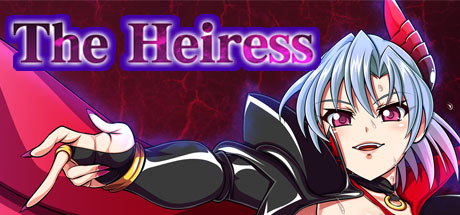

The AppID on Steam for the Game is 680320
The Game Developer = The Heiress
The Game Publisher is ['Paradise Project']
The game was developed by ['ONEONE1']
The game was released on Aug 11, 2017
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Indie', 'RPG']
These are the following tags classified under the game : ['SexualContent', 'Nudity', 'RPG', 'Mature', 'Anime', 'FemaleProtagonist', 'JRPG', 'RPGMaker', 'Singleplayer', 'Indie', 'Cute', 'Adventure', 'DungeonCrawler', 'VisualNovel', 'StoryRich', 'Funny', 'Hentai', 'NSFW']
The following are the total reviews 1571
The following is the Positive Reviews/Total Reviews : 0.8688733290897518
The Game Currently Costs ... 0.0


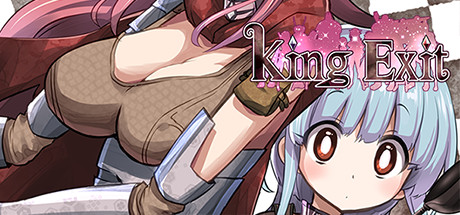

The AppID on Steam for the Game is 712840
The Game Developer = King Exit
The Game Publisher is ['Paradise Project']
The game was developed by ['深爪貴族']
The game was released on Oct 19, 2017
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Indie', 'RPG']
These are the following tags classified under the game : ['SexualContent', 'Nudity', 'RPGMaker', 'RPG', 'StoryRich', 'Adventure', 'Mature', 'Anime', 'Indie', 'FemaleProtagonist', 'Hentai', 'VisualNovel', 'NSFW', 'JRPG', 'Singleplayer', 'GreatSoundtrack', 'FPS']
The following are the total reviews 6572
The following is the Positive Reviews/Total Reviews : 0.9529823493609252
The Game Currently Costs ... 0.0


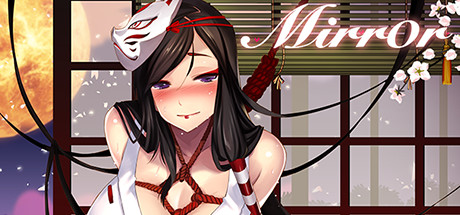

The AppID on Steam for the Game is 644560
The Game Developer = Mirror
The Game Publisher is ['Paradise Project']
The game was developed by ['KAGAMI WORKS']
The game was released on Apr 19, 2018
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Indie', 'RPG']
These are the following tags classified under the game : ['SexualContent', 'Nudity', 'Hentai', 'Mature', 'Anime', 'NSFW', 'Match', 'FemaleProtagonist', 'VisualNovel', 'DatingSim', 'Singleplayer', 'RPG', 'Cute', 'StoryRich', 'Puzzle', 'Adventure', 'JRPG', 'Indie', 'Shooter', 'Casual']
The following are the total reviews 82973
The following is the Positive Reviews/Total Reviews : 0.9692189025345594
The Game Currently Costs ... 1.99


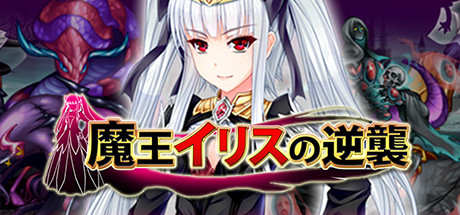

The AppID on Steam for the Game is 711990
The Game Developer = Elise the Devil
The Game Publisher is ['Paradise Project']
The game was developed by ['Dieselmine']
The game was released on Nov 1, 2017
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Indie', 'RPG']
These are the following tags classified under the game : ['SexualContent', 'Nudity', 'Mature', 'RPG', 'RPGMaker', 'Adventure', 'Anime', 'Indie', 'FemaleProtagonist', 'JRPG', 'Singleplayer', 'Hentai', 'NSFW']
The following are the total reviews 2241
The following is the Positive Reviews/Total Reviews : 0.929941990182954
The Game Currently Costs ... 0.0


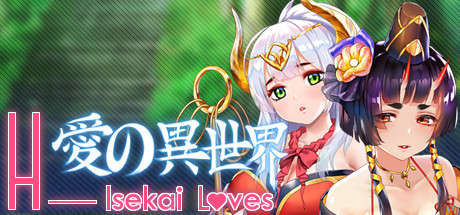

The AppID on Steam for the Game is 1660280
The Game Developer = H-Isekai Loves
The Game Publisher is ['G-Blood']
The game was developed by ['G-Blood']
The game was released on Feb 11, 2022
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Casual', 'Indie', 'RPG', 'Simulation']
These are the following tags classified under the game : ['SexualContent', 'Nudity', 'Hentai', 'Mature', 'NSFW', 'Anime', 'Match', 'VisualNovel', 'DatingSim', 'Singleplayer', 'Cute', 'FemaleProtagonist', 'RPG', 'StoryRich', 'Puzzle', 'Adventure', 'Shooter', 'JRPG', 'Casual', 'FPS']
The following are the total reviews 953
The following is the Positive Reviews/Total Reviews : 0.8614900314795383
The Game Currently Costs ... 2.99


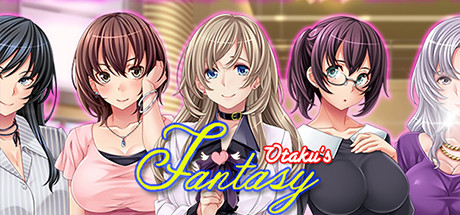

The AppID on Steam for the Game is 712050
The Game Developer = Otaku's Fantasy
The Game Publisher is ['Paradise Project']
The game was developed by ['Dieselmine']
The game was released on Oct 11, 2017
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Casual', 'Indie']
These are the following tags classified under the game : ['SexualContent', 'Nudity', 'Mature', 'Anime', 'VisualNovel', 'Adventure', 'Indie', 'Casual', 'Hentai', 'DatingSim', 'NSFW']
The following are the total reviews 3030
The following is the Positive Reviews/Total Reviews : 0.8848184818481848
The Game Currently Costs ... 0.0


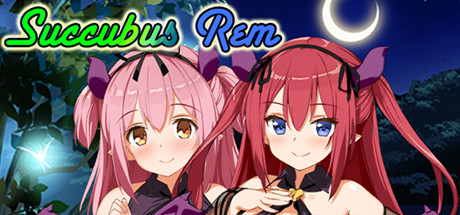

The AppID on Steam for the Game is 726990
The Game Developer = Succubus Rem
The Game Publisher is ['Paradise Project']
The game was developed by ['とらいあんぐる！']
The game was released on Dec 19, 2017
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Indie', 'RPG']
These are the following tags classified under the game : ['SexualContent', 'Nudity', 'RPG', 'Indie', 'Anime', 'RPGMaker', 'FemaleProtagonist', 'Mature', 'Hentai', 'Adventure', 'NSFW']
The following are the total reviews 941
The following is the Positive Reviews/Total Reviews : 0.900106269925611
The Game Currently Costs ... 0.0


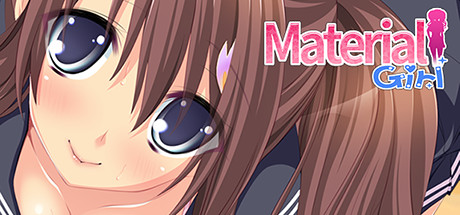

The AppID on Steam for the Game is 644570
The Game Developer = Material Girl
The Game Publisher is ['Paradise Project']
The game was developed by ['Dieselmine']
The game was released on Jun 20, 2017
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Indie', 'RPG']
These are the following tags classified under the game : ['SexualContent', 'Nudity', 'Mature', 'Anime', 'FemaleProtagonist', 'RPGMaker', 'RPG', 'Adventure', 'Indie', 'Singleplayer', 'FPS', 'NSFW', 'VisualNovel', 'StoryRich', 'DatingSim', 'OpenWorld', 'Simulation', 'Action', 'GreatSoundtrack', 'Casual']
The following are the total reviews 8047
The following is the Positive Reviews/Total Reviews : 0.9145022989934136
The Game Currently Costs ... 1.99


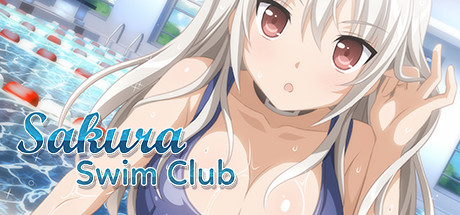

The AppID on Steam for the Game is 402180
The Game Developer = Sakura Swim Club
The Game Publisher is ['Winged Cloud']
The game was developed by ['Winged Cloud']
The game was released on Sep 11, 2015
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Casual', 'Indie']
These are the following tags classified under the game : ['Nudity', 'Anime', 'Mature', 'SexualContent', 'VisualNovel', 'DatingSim', 'Indie', 'Hentai', 'Casual', 'Singleplayer', 'Cute', 'StoryRich', 'Romance', 'Memes', 'D', 'Illuminati', 'FemaleProtagonist', 'Adventure', 'NSFW', 'FPS']
The following are the total reviews 2814
The following is the Positive Reviews/Total Reviews : 0.8546552949538024
The Game Currently Costs ... 9.99


,AppID,Name,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment
1,680320,The Heiress,[Paradise Project],[ONEONE1],"Aug 11, 2017",0.00,"[Singleplayer, ]","[Adventure, Indie, RPG]","[SexualContent, Nudity, RPG, Mature, Anime, Fe...",1571,0.87
2,712840,King Exit,[Paradise Project],[深爪貴族],"Oct 19, 2017",0.00,"[Singleplayer, ]","[Adventure, Indie, RPG]","[SexualContent, Nudity, RPGMaker, RPG, StoryRi...",6572,0.95
3,644560,Mirror,[Paradise Project],[KAGAMI WORKS],"Apr 19, 2018",1.99,"[Singleplayer, ]","[Adventure, Indie, RPG]","[SexualContent, Nudity, Hentai, Mature, Anime,...",82973,0.97
4,711990,Elise the Devil,[Paradise Project],[Dieselmine],"Nov 1, 2017",0.00,"[Singleplayer, ]","[Adventure, Indie, RPG]","[SexualContent, Nudity, Mature, RPG, RPGMaker,...",2241,0.93
5,1660280,H-Isekai Loves,[G-Blood],[G-Blood],"Feb 11, 2022",2.99,"[Singleplayer, ]","[Adventure, Casual, Indie, RPG, Simulation]","[SexualContent, Nudity, Hentai, Mature, NSFW, ...",953,0.86
6,712050,Otaku's Fantasy,[Paradise Project],[Dieselmine],"Oct 11, 2017",0.00,"[Singleplayer, ]","[Adventure, Casual, Indie]","[SexualContent, Nudity, Mature, Anime, VisualN...",3030,0.88
7,726990,Succubus Rem,[Paradise Project],[とらいあんぐる！],"Dec 19, 2017",0.00,"[Singleplayer, ]","[Indie, RPG]","[SexualContent, Nudity, RPG, Indie, Anime, RPG...",941,0.90
8,644570,Material Girl,[Paradise Project],[Dieselmine],"Jun 20, 2017",1.99,"[Singleplayer, ]","[Adventure, Indie, RPG]","[SexualContent, Nudity, Mature, Anime, FemaleP...",8047,0.91
9,402180,Sakura Swim Club,[Winged Cloud],[Winged Cloud],"Sep 11, 2015",9.99,"[Singleplayer, ]","[Casual, Indie]","[Nudity, Anime, Mature, SexualContent, VisualN...",2814,0.85


In [45]:
#The top is an user input for the game of interest, and the number of recs
game = input('Game Name: ')
recs = input('Number of Recommendations: ')
SteamRecommendMe(game,recs)

# Creating the Recommender System with Multiple Entries

In [46]:
#Putting multiple games into one to see if we can handle multiple game recs at once
def SteamRecommendMeMany(game,game2,game3,game4,recs):
    if game != "":
        #This limits the game and finds the index at which it is aka the APPID, this will refer back to the actual dataframe not the mlb one later
        game = steam.index[steam.Name == game]
        # Pulling out an individual row indexed by steam app ID
        y = np.array(mlb_df.loc[game])
        # Need to reshape so it can be passed into cosine_sim function
        y = y.reshape(1, -1)
        # Utilize cosine_similarity from sklearn to return similarity scores based on cosine distance
        cos_sim = cosine_similarity(mlb_df, y)
        cos_sim = pd.DataFrame(data=cos_sim, index=mlb_df.index)
        cos_tot = cos_sim
        numct = 1
    if game2 != "":
        #This limits the game and finds the index at which it is aka the APPID, this will refer back to the actual dataframe not the mlb one later
        game2 = steam.index[steam.Name == game2]
        # Pulling out an individual row indexed by steam app ID
        y2 = np.array(mlb_df.loc[game2])
        # Need to reshape so it can be passed into cosine_sim function
        y2 = y2.reshape(1, -1)
        # Utilize cosine_similarity from sklearn to return similarity scores based on cosine distance
        cos_sim2 = cosine_similarity(mlb_df, y2)
        cos_sim2 = pd.DataFrame(data=cos_sim2, index=mlb_df.index)
        cos_tot = cos_tot + cos_sim2
        numct = numct + 1
    if game3 != "":
        #This limits the game and finds the index at which it is aka the APPID, this will refer back to the actual dataframe not the mlb one later
        game3 = steam.index[steam.Name == game3]
        # Pulling out an individual row indexed by steam app ID
        y3 = np.array(mlb_df.loc[game3])
        # Need to reshape so it can be passed into cosine_sim function
        y3 = y3.reshape(1, -1)
        # Utilize cosine_similarity from sklearn to return similarity scores based on cosine distance
        cos_sim3 = cosine_similarity(mlb_df, y3)
        cos_sim3 = pd.DataFrame(data=cos_sim3, index=mlb_df.index)
        cos_tot = cos_tot + cos_sim3
        numct = numct + 1
    if game4 != "":
        #This limits the game and finds the index at which it is aka the APPID, this will refer back to the actual dataframe not the mlb one later
        game4 = steam.index[steam.Name == game4]
        # Pulling out an individual row indexed by steam app ID
        y4 = np.array(mlb_df.loc[game4])
        # Need to reshape so it can be passed into cosine_sim function
        y4 = y4.reshape(1, -1)
        # Utilize cosine_similarity from sklearn to return similarity scores based on cosine distance
        cos_sim4 = cosine_similarity(mlb_df, y4)
        cos_sim4 = pd.DataFrame(data=cos_sim4, index=mlb_df.index)
        cos_tot = cos_tot + cos_sim4
        numct = numct + 1
    cos_tot.sort_values(cos_tot.columns[0], ascending = False).head(int(recs)+numct)
    results = cos_tot.sort_values(cos_tot.columns[0], ascending = False).head(int(recs)+numct).index
    # Using returned results variable I can index the original meta data frame to return appropriate information for each book
    steamresults = steam.loc[results]
    steamresults.reset_index(inplace=True)
    pd.options.display.float_format = '{:.2f}'.format
    recommendations = steamresults[['AppID', 'Name','Publisher','Developer','Release_Date','Price','Categories','Genres', 'Tags', 'Total_Reviews'
            ,'Sentiment']].iloc[numct: , :]
    for appid in list(results)[numct:]:
        display(Image("https://cdn.akamai.steamstatic.com/steam/apps/"+str(appid)+"/header.jpg"))
        display(HTML("""<a href=https://store.steampowered.com/app/%s/">Steam Website Link</a>"""%(appid)))
        print("The AppID on Steam for the Game is "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].AppID.values)))
        print("The Game Developer = "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Name.values)))
        print("The Game Publisher is "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Publisher.values)))
        print("The game was developed by "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Developer.values)))
        print("The game was released on "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Release_Date.values)))
        print("These are the following categories classified under the game : "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Categories.values)))
        print("These are the following genres classified under the game : "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Genres.values)))
        print("These are the following tags classified under the game : "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Tags.values)))
        print("The following are the total reviews "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Total_Reviews.values)))
        print("The following is the Positive Reviews/Total Reviews : "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Sentiment.values)))
        print("The Game Currently Costs ... "+ " ".join(map(str,steamresults.loc[steamresults.AppID == appid].Price.values)))
    # Changing certain columns to display integer instead of float for more appealing final display
    return(recommendations)

Game Name: STEINS;GATE
Game Name(Leave Empty if No Further): 
Game Name(Leave Empty if No Further): 
Game Name(Leave Empty if No Further): 
Number of Recommendations: 10


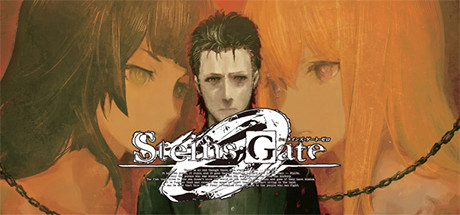

The AppID on Steam for the Game is 825630
The Game Developer = STEINS;GATE 0
The Game Publisher is ['Spike Chunsoft Co., Ltd.']
The game was developed by ['MAGES. Inc.']
The game was released on May 8, 2018
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure']
These are the following tags classified under the game : ['VisualNovel', 'StoryRich', 'Anime', 'TimeTravel', 'Sci-fi', 'GreatSoundtrack', 'Adventure', 'MultipleEndings', 'Singleplayer', 'Science', 'ChoicesMatter', 'ArtificialIntelligence', 'PsychologicalHorror', 'Mystery', 'Romance', 'Psychological', 'Atmospheric', 'Violent', 'Memes']
The following are the total reviews 4341
The following is the Positive Reviews/Total Reviews : 0.96222068647777
The Game Currently Costs ... 34.99


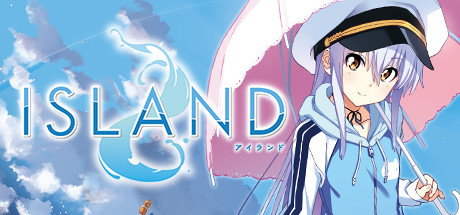

The AppID on Steam for the Game is 857450
The Game Developer = ISLAND
The Game Publisher is ['Frontwing USA']
The game was developed by ['Frontwing']
The game was released on Aug 23, 2018
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Casual']
These are the following tags classified under the game : ['VisualNovel', 'Anime', 'StoryRich', 'Adventure', 'Cute', 'TimeTravel', 'Casual', 'Mystery', 'Sci-fi', 'SexualContent', 'Romance', 'ChoicesMatter', 'MultipleEndings', 'Singleplayer', 'PsychologicalHorror', 'DatingSim', 'Drama', 'Horror', 'Nudity', 'GreatSoundtrack']
The following are the total reviews 1219
The following is the Positive Reviews/Total Reviews : 0.9614438063986874
The Game Currently Costs ... 29.99


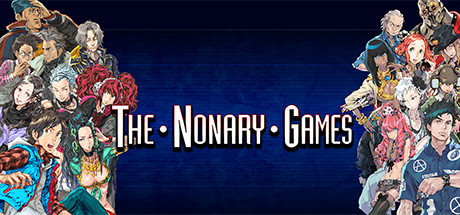

The AppID on Steam for the Game is 477740
The Game Developer = Zero Escape: The Nonary Games
The Game Publisher is ['Spike Chunsoft Co., Ltd.']
The game was developed by ['Spike Chunsoft Co., Ltd.']
The game was released on Mar 24, 2017
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure']
These are the following tags classified under the game : ['VisualNovel', 'StoryRich', 'Puzzle', 'Mystery', 'ChoicesMatter', 'MultipleEndings', 'PsychologicalHorror', 'Anime', 'Adventure', 'GreatSoundtrack', 'Atmospheric', 'Sci-fi', 'Singleplayer', 'Point&Click', 'Horror', 'EscapeRoom', 'Gore', 'Violent', 'Detective', 'TimeTravel']
The following are the total reviews 3930
The following is the Positive Reviews/Total Reviews : 0.94529262086514
The Game Currently Costs ... 29.99


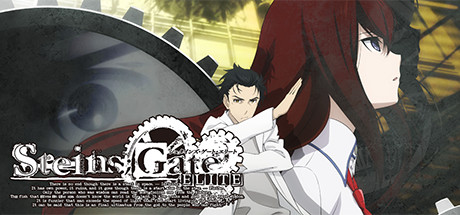

The AppID on Steam for the Game is 819030
The Game Developer = STEINS;GATE ELITE
The Game Publisher is ['Spike Chunsoft Co., Ltd.']
The game was developed by ['MAGES. Inc.']
The game was released on Feb 19, 2019
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure']
These are the following tags classified under the game : ['VisualNovel', 'Anime', 'TimeTravel', 'Sci-fi', 'StoryRich', 'Adventure', 'GreatSoundtrack', 'Singleplayer', 'Violent', 'Gore', 'ChoicesMatter', 'MultipleEndings', 'Science', 'Thriller', 'Romance', 'Remake', 'Drama']
The following are the total reviews 1094
The following is the Positive Reviews/Total Reviews : 0.9149908592321756
The Game Currently Costs ... 59.99


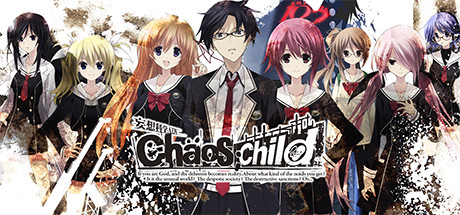

The AppID on Steam for the Game is 970570
The Game Developer = CHAOS;CHILD
The Game Publisher is ['Spike Chunsoft Co., Ltd.']
The game was developed by ['MAGES. Inc.']
The game was released on Jan 22, 2019
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure']
These are the following tags classified under the game : ['VisualNovel', 'Mystery', 'Anime', 'StoryRich', 'Violent', 'Gore', 'Adventure', 'PsychologicalHorror', 'GreatSoundtrack', 'Horror', 'Sci-fi', 'MultipleEndings', 'SexualContent', 'Nudity', 'Psychological', 'Atmospheric', 'Thriller', 'Singleplayer', 'Science', 'Emotional']
The following are the total reviews 1992
The following is the Positive Reviews/Total Reviews : 0.9382530120481928
The Game Currently Costs ... 34.99


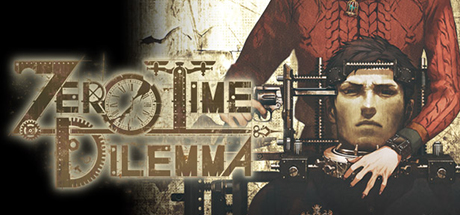

The AppID on Steam for the Game is 311240
The Game Developer = Zero Escape: Zero Time Dilemma
The Game Publisher is ['Spike Chunsoft Co., Ltd.']
The game was developed by ['Spike Chunsoft Co., Ltd.']
The game was released on Jun 29, 2016
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure']
These are the following tags classified under the game : ['Puzzle', 'VisualNovel', 'PsychologicalHorror', 'StoryRich', 'Mystery', 'ChoicesMatter', 'Adventure', 'Anime', 'Sci-fi', 'Horror', 'Singleplayer', 'GreatSoundtrack', 'MultipleEndings', 'Mature', 'Gore', 'Thriller', 'Atmospheric', 'Point&Click', 'EscapeRoom', 'Dark']
The following are the total reviews 3188
The following is the Positive Reviews/Total Reviews : 0.8553952321204517
The Game Currently Costs ... 19.99


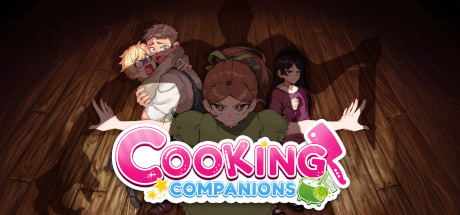

The AppID on Steam for the Game is 1263230
The Game Developer = Cooking Companions
The Game Publisher is ['Deer Dream Studios']
The game was developed by ['Deer Dream Studios']
The game was released on Oct 7, 2021
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure', 'Casual', 'Indie']
These are the following tags classified under the game : ['VisualNovel', 'PsychologicalHorror', 'Cute', 'Anime', 'MultipleEndings', 'Horror', 'Mystery', 'StoryRich', 'Casual', 'Atmospheric', 'ChooseYourOwnAdventure', 'Singleplayer', 'Indie', 'DatingSim', 'ChoicesMatter', 'Adventure', 'Cooking']
The following are the total reviews 677
The following is the Positive Reviews/Total Reviews : 0.9601181683899556
The Game Currently Costs ... 14.99


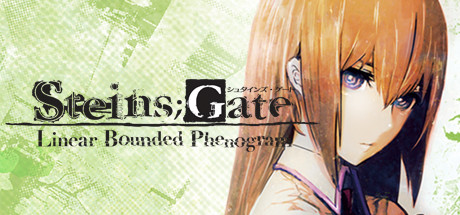

The AppID on Steam for the Game is 930910
The Game Developer = STEINS;GATE: Linear Bounded Phenogram
The Game Publisher is ['Spike Chunsoft Co., Ltd.']
The game was developed by ['MAGES. Inc.']
The game was released on Feb 19, 2019
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure']
These are the following tags classified under the game : ['Adventure', 'VisualNovel', 'Anime', 'StoryRich', 'Sci-fi', 'TimeTravel', 'Singleplayer', 'GreatSoundtrack']
The following are the total reviews 514
The following is the Positive Reviews/Total Reviews : 0.9766536964980544
The Game Currently Costs ... 59.99


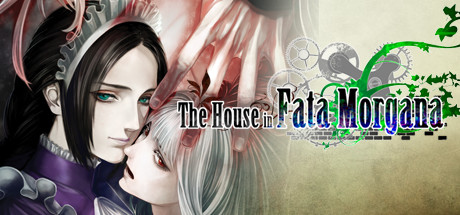

The AppID on Steam for the Game is 303310
The Game Developer = The House in Fata Morgana
The Game Publisher is ['MangaGamer']
The game was developed by ['NOVECT']
The game was released on May 13, 2016
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure']
These are the following tags classified under the game : ['VisualNovel', 'GreatSoundtrack', 'StoryRich', 'Gothic', 'Mystery', 'PsychologicalHorror', 'Atmospheric', 'Horror', 'Romance', 'Adventure', 'Anime', 'Dark', 'Indie', 'Philosophical', 'LGBTQ+', 'Singleplayer', 'D', 'ChoicesMatter', 'MultipleEndings', 'FemaleProtagonist']
The following are the total reviews 2759
The following is the Positive Reviews/Total Reviews : 0.9565059804276912
The Game Currently Costs ... 24.99


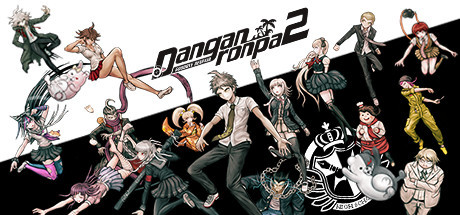

The AppID on Steam for the Game is 413420
The Game Developer = Danganronpa 2: Goodbye Despair
The Game Publisher is ['Spike Chunsoft Co., Ltd.']
The game was developed by ['Spike Chunsoft Co., Ltd., Abstraction Games']
The game was released on Apr 18, 2016
These are the following categories classified under the game : ['Singleplayer', '']
These are the following genres classified under the game : ['Adventure']
These are the following tags classified under the game : ['Anime', 'Detective', 'VisualNovel', 'Mystery', 'StoryRich', 'GreatSoundtrack', 'Singleplayer', 'PsychologicalHorror', 'Adventure', 'DarkComedy', 'Horror', 'Puzzle', 'Atmospheric', 'Dark', 'Comedy', 'Memes', 'DatingSim', 'Mature', 'Funny', 'WalkingSimulator']
The following are the total reviews 20684
The following is the Positive Reviews/Total Reviews : 0.964320247534326
The Game Currently Costs ... 19.99


,AppID,Name,Publisher,Developer,Release_Date,Price,Categories,Genres,Tags,Total_Reviews,Sentiment
1,825630,STEINS;GATE 0,"[Spike Chunsoft Co., Ltd.]",[MAGES. Inc.],"May 8, 2018",34.99,"[Singleplayer, ]",[Adventure],"[VisualNovel, StoryRich, Anime, TimeTravel, Sc...",4341,0.96
2,857450,ISLAND,[Frontwing USA],[Frontwing],"Aug 23, 2018",29.99,"[Singleplayer, ]","[Adventure, Casual]","[VisualNovel, Anime, StoryRich, Adventure, Cut...",1219,0.96
3,477740,Zero Escape: The Nonary Games,"[Spike Chunsoft Co., Ltd.]","[Spike Chunsoft Co., Ltd.]","Mar 24, 2017",29.99,"[Singleplayer, ]",[Adventure],"[VisualNovel, StoryRich, Puzzle, Mystery, Choi...",3930,0.95
4,819030,STEINS;GATE ELITE,"[Spike Chunsoft Co., Ltd.]",[MAGES. Inc.],"Feb 19, 2019",59.99,"[Singleplayer, ]",[Adventure],"[VisualNovel, Anime, TimeTravel, Sci-fi, Story...",1094,0.91
5,970570,CHAOS;CHILD,"[Spike Chunsoft Co., Ltd.]",[MAGES. Inc.],"Jan 22, 2019",34.99,"[Singleplayer, ]",[Adventure],"[VisualNovel, Mystery, Anime, StoryRich, Viole...",1992,0.94
6,311240,Zero Escape: Zero Time Dilemma,"[Spike Chunsoft Co., Ltd.]","[Spike Chunsoft Co., Ltd.]","Jun 29, 2016",19.99,"[Singleplayer, ]",[Adventure],"[Puzzle, VisualNovel, PsychologicalHorror, Sto...",3188,0.86
7,1263230,Cooking Companions,[Deer Dream Studios],[Deer Dream Studios],"Oct 7, 2021",14.99,"[Singleplayer, ]","[Adventure, Casual, Indie]","[VisualNovel, PsychologicalHorror, Cute, Anime...",677,0.96
8,930910,STEINS;GATE: Linear Bounded Phenogram,"[Spike Chunsoft Co., Ltd.]",[MAGES. Inc.],"Feb 19, 2019",59.99,"[Singleplayer, ]",[Adventure],"[Adventure, VisualNovel, Anime, StoryRich, Sci...",514,0.98
9,303310,The House in Fata Morgana,[MangaGamer],[NOVECT],"May 13, 2016",24.99,"[Singleplayer, ]",[Adventure],"[VisualNovel, GreatSoundtrack, StoryRich, Goth...",2759,0.96
10,413420,Danganronpa 2: Goodbye Despair,"[Spike Chunsoft Co., Ltd.]","[Spike Chunsoft Co., Ltd., Abstraction Games]","Apr 18, 2016",19.99,"[Singleplayer, ]",[Adventure],"[Anime, Detective, VisualNovel, Mystery, Story...",20684,0.96


In [48]:
#The top is an user input for the game of interest, and the number of recs
game = input('Game Name: ')
game2 = input('Game Name(Leave Empty if No Further): ')
game3 = input('Game Name(Leave Empty if No Further): ')
game4 = input('Game Name(Leave Empty if No Further): ')
recs = input('Number of Recommendations: ')
SteamRecommendMeMany(game,game2,game3,game4,recs)

# Conclusion

The Recommendation System that has been built can take game names and also the number of recommendations to output. All an user has to input is the the game or games they are interested in as well as the number of recommendations, and this will spew out a number of recommendations for them. The recommendations are from Steam and consist of games with more than 100 reviews and will output the APPID, Game Name, as well as several other key information that could play a big role in the decision of the individual.
In conclusion, I built a recommender system that takes into account the Publisher, Developer, Categories, Genres, Tags, Price Range, Sentiment Range, and Popularity to try finding games of the most similar nature. Unfortunately, I have also come to kind of see the flaws of content based recommendation system as it seems to just try to find stuff of similar attributes and it completely dependent on the dataset, but perhaps it is difficult to put weighing on certain stuff with how I went about the project. For example, if there were a hundred input for categories but only only one for all other columns, it would be heavily skewed towards the category section. Perhaps a review word vectorizer or perhaps one for the game description would have been a lot more interesting to have done the recommender system on.
Due to the fact that the project itself has not been overly complex with models and scoring to keep track of, I tried to improve the user experience by providing recommendations with jpegs pulled from the Steam website itself (so images will not be saved onto the local computer) and a link to the game itself.